In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


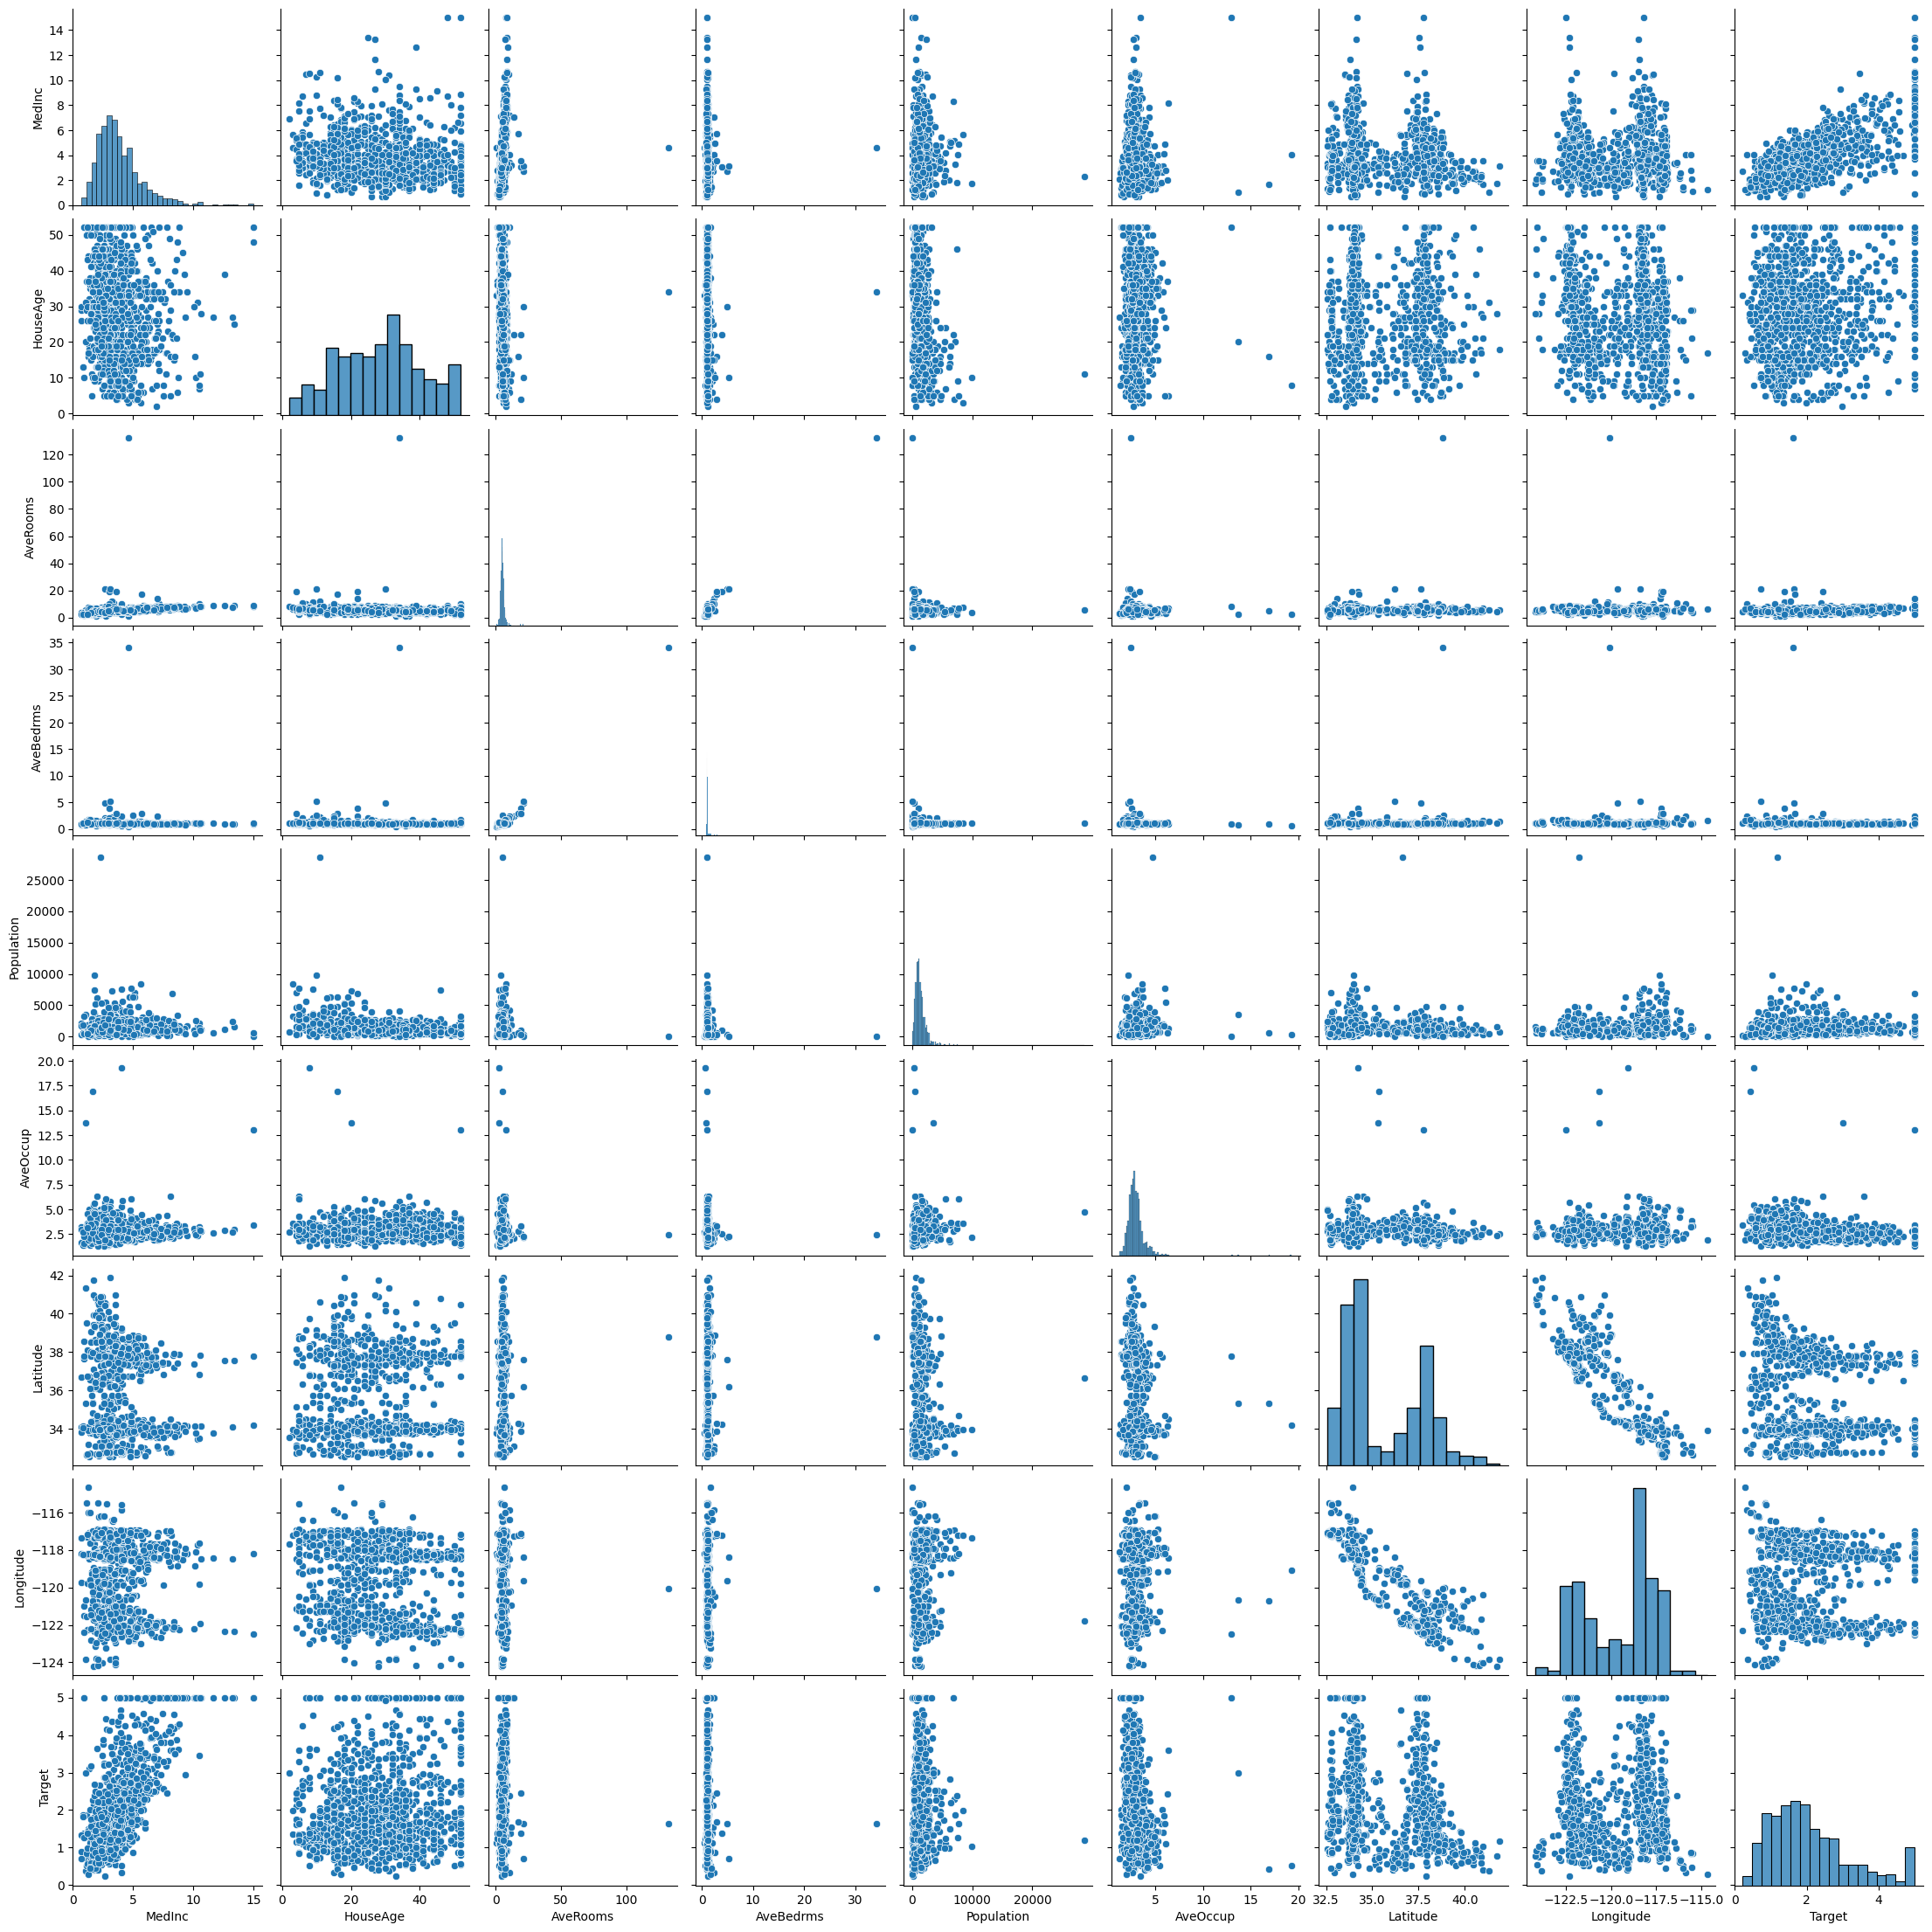

In [3]:
sns.pairplot(df.sample(1000))
plt.show()

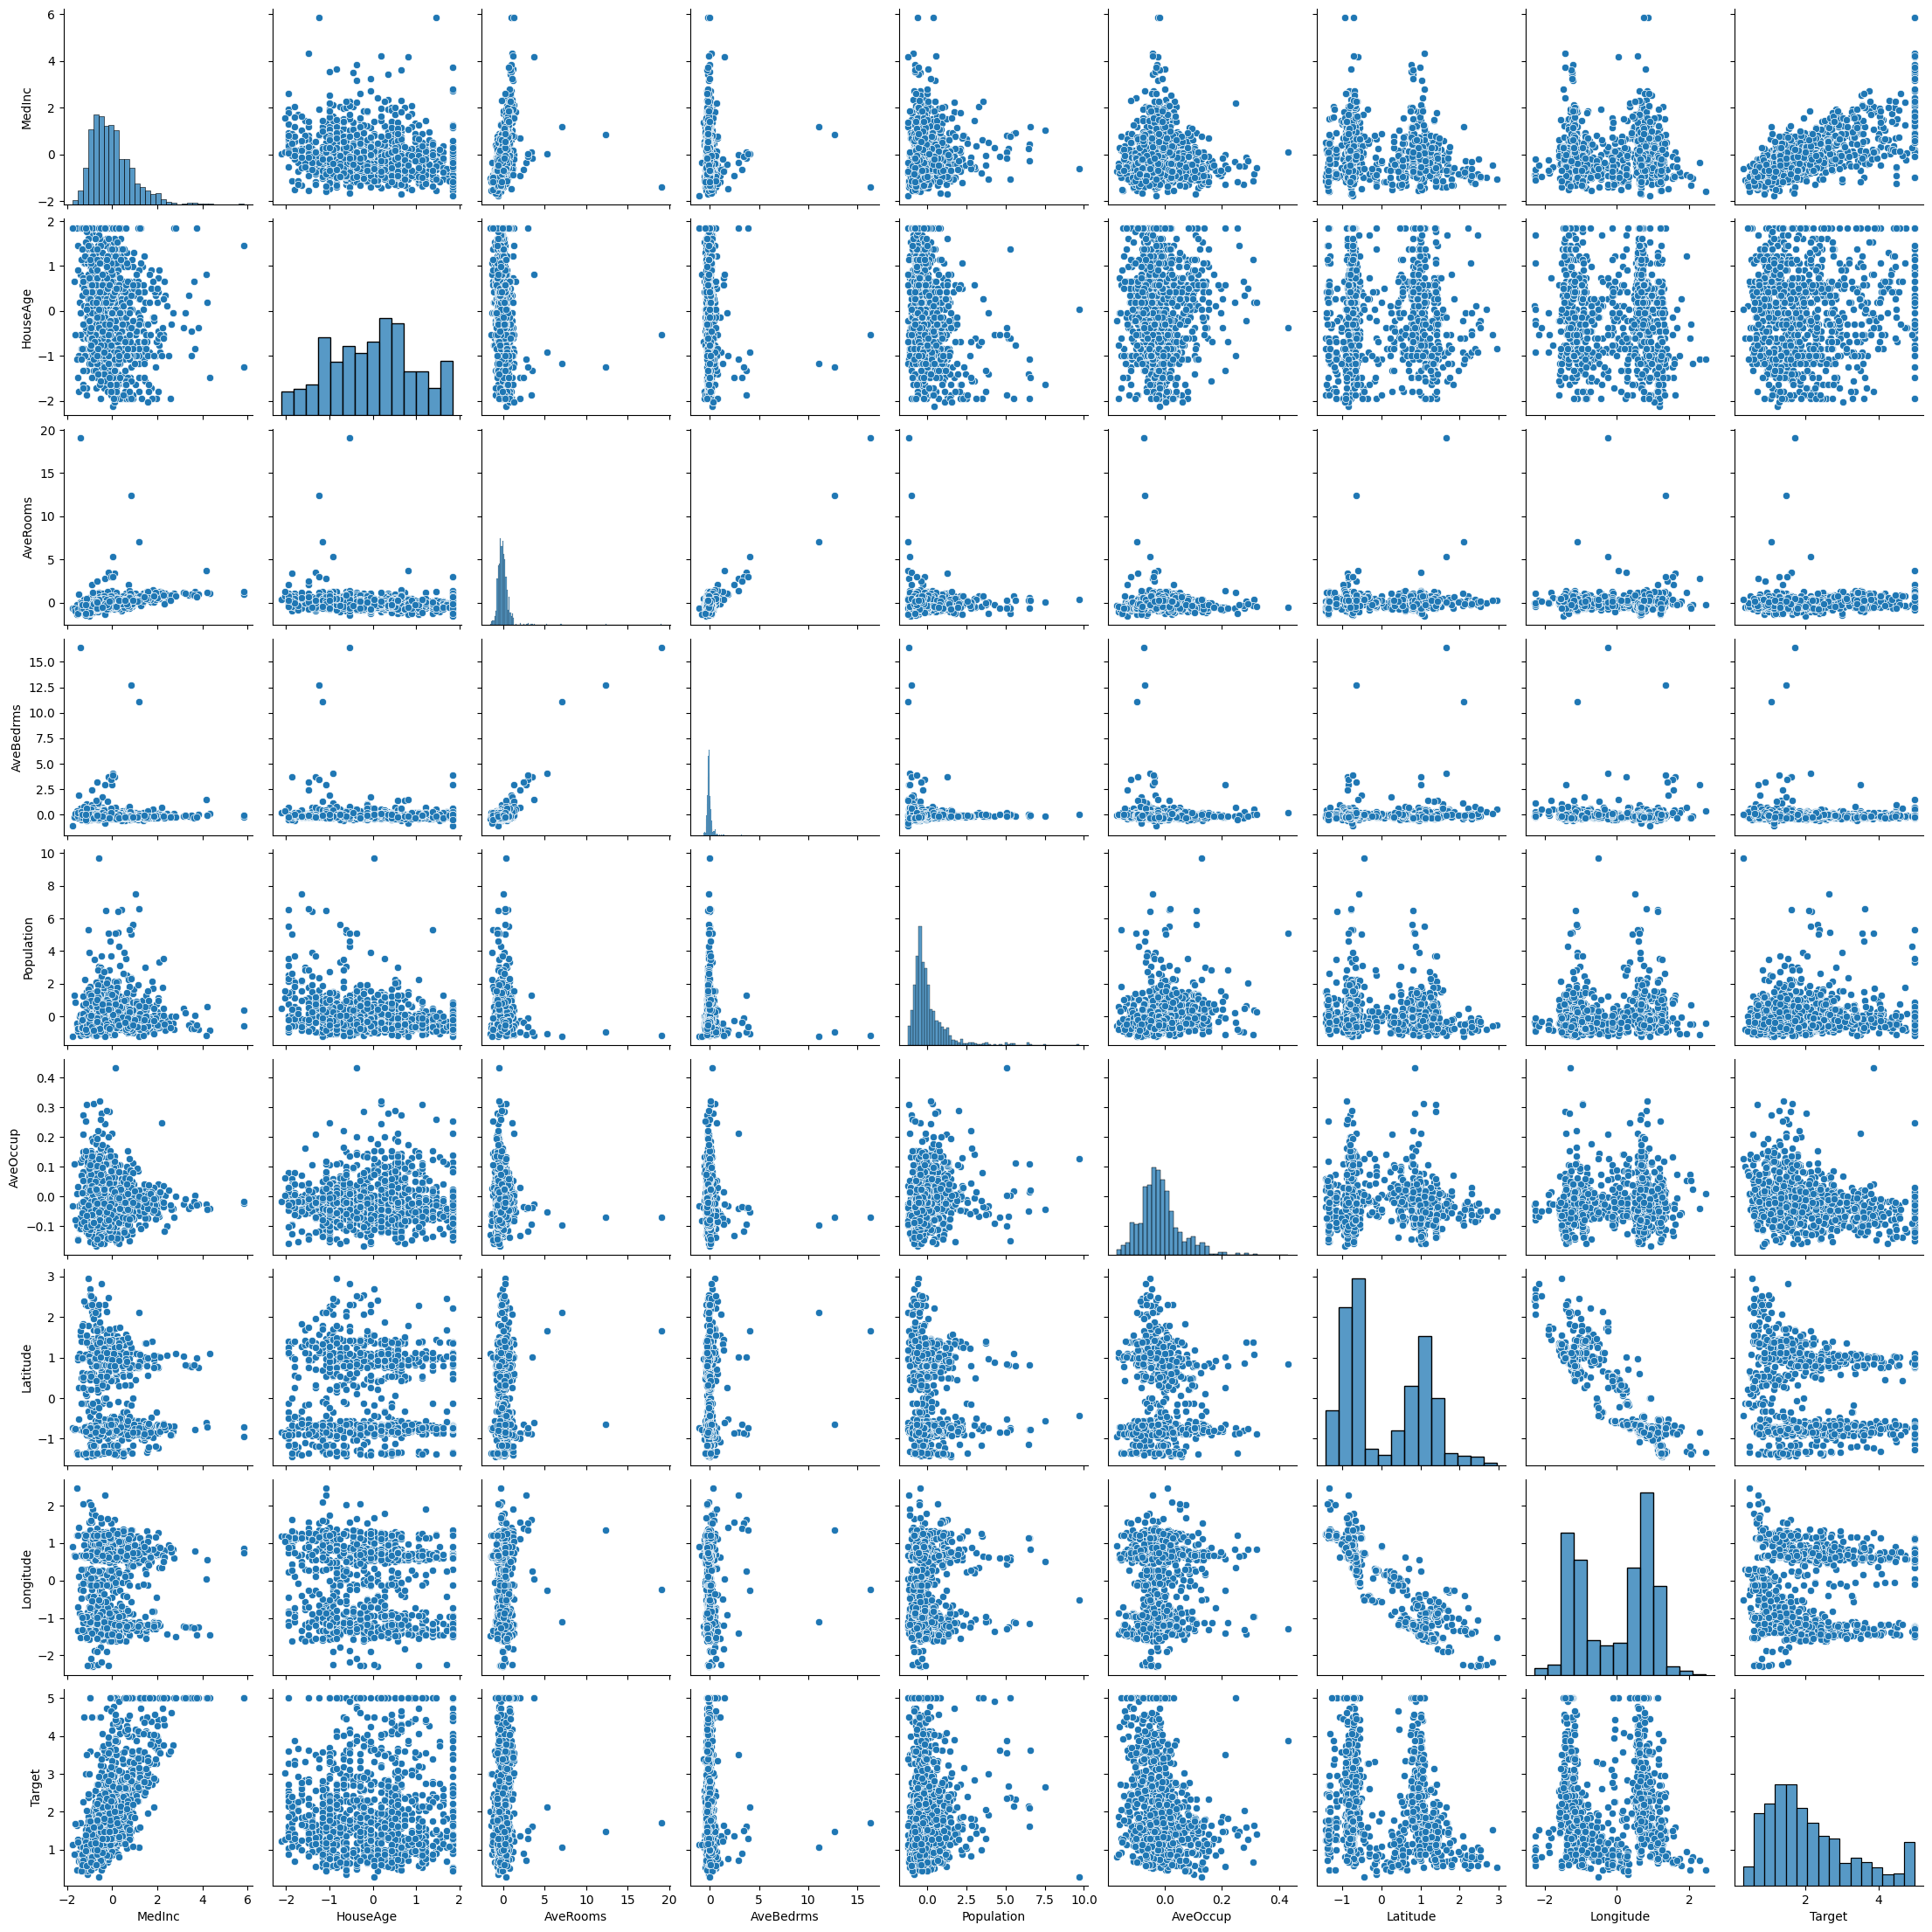

In [4]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.iloc[:, : -1] = scaler.transform(df.values[:, :-1])

sns.pairplot(df.sample(1000))
plt.show()

In [5]:
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,0.781
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,0.771
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,0.923
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,0.847
20639,-0.780129,-1.004309,-0.070443,0.138403,-0.033977,-0.043682,1.750146,-0.833696,0.894


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
data = torch.from_numpy(df.values).float()
print(data.shape)

torch.Size([20640, 9])


In [8]:
x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [9]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

In [10]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [11]:
optimizer = optim.Adam(model.parameters())

In [12]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)
for i in range(n_epochs):
    # Shuffle the index to feed-forward
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        total_loss += float(loss) # This is very important to prevent memory leak
        y_hat += [y_hat_i]
        total_loss = total_loss / len(x_)

    if(i + 1) % print_interval == 0:
        print('epoch %d : loss=%.4e' % (i + 1, total_loss))
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)       

epoch 200 : loss=3.6870e-03
epoch 400 : loss=4.0058e-03
epoch 600 : loss=5.3336e-03
epoch 800 : loss=2.8367e-03
epoch 1000 : loss=3.9937e-03
epoch 1200 : loss=4.4754e-03
epoch 1400 : loss=5.1641e-03
epoch 1600 : loss=2.6960e-03
epoch 1800 : loss=3.0802e-03
epoch 2000 : loss=3.8807e-03
epoch 2200 : loss=3.1286e-03
epoch 2400 : loss=2.2632e-03
epoch 2600 : loss=3.9341e-03
epoch 2800 : loss=5.7378e-03
epoch 3000 : loss=3.4440e-03
epoch 3200 : loss=3.1139e-03
epoch 3400 : loss=3.8694e-03
epoch 3600 : loss=3.7146e-03
epoch 3800 : loss=4.0266e-03
epoch 4000 : loss=3.3681e-03


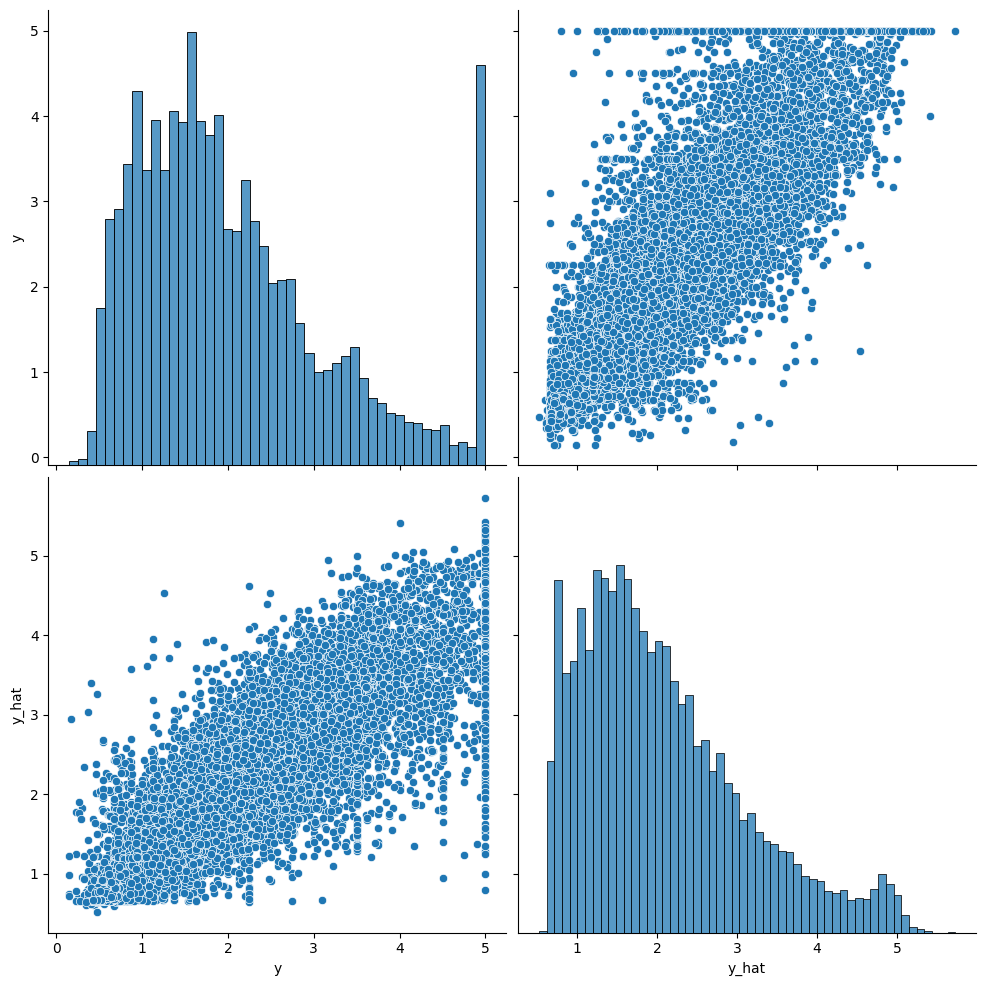

In [13]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=["y", "y_hat"])

sns.pairplot(df, height = 5)
plt.show()